### **Import Libraries and Packages**

In [1]:
import os 
import time
import csv
import cv2
import copy
import  random
from datetime import datetime
from pathlib import Path
from typing import Tuple, Dict, Optional, Any
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models 

from torchmetrics.classification import BinaryF1Score, BinaryRecall, BinaryAccuracy, BinaryPrecision, BinarySpecificity, BinaryAUROC, BinaryAveragePrecision
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
torch.set_float32_matmul_precision('high')

#set seed for reproducibility of results 
seed_value = 18

# Set seed for torch (for CPU)
torch.manual_seed(seed_value)
# Set seed for torch (for GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
# Ensure that cuDNN works deterministically
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 


In [2]:
# setting up device 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [3]:
os.chdir('../')
%pwd

'/home/akshar/Omdena/TB Detection/github/Omdena-PuneIndiaChapter-EarlyDetectionTuberculosis'

In [45]:
from src.utils import calculate_class_weights, update_config, read_yaml, save_model_state
from src.constants import CLF_DATA_DIR, PROC_DATA_DIR, CLF_MODEL_DIR, EXPERIMENT_LOG_FILE

Create a CSV file With Image Paths and Labels 

#### **DataSet Creation**

In [5]:
class TBImageDataset(Dataset):
    def __init__(self, df=None, base_dir=None, resize=None,transform=None):
        self.data = df
        self.base_dir = Path(base_dir)
        self.resize = resize
        self.transform = transform
        self.labels = [1 if label == 'tb_positive' else 0 for label in self.data.iloc[:, 1]]
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_rel_path = self.data.iloc[idx, 0]  # Assuming first column is the image path
        label = self.labels[idx]    # Assuming second column is the label
        img_path = self.base_dir / img_rel_path
        
        try:
            # load and resize image using OpenCV
            image = cv2.imread(str(img_path))

            if image is None:
                raise ValueError(f"Image not found or unable to read: {img_path}")
            if self.resize is not None:
                image_resized = cv2.resize(image, (self.resize, self.resize), interpolation=cv2.INTER_LINEAR)

            if self.transform is not None:
                image = self.transform(image=image_resized)['image']
            # Convert label to binary (0 for tb_negative, 1 for tb_positive)
            label = torch.tensor(label, dtype=torch.long)
            return image, label  
        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None

### **Aumentation and Enhancement** 

In [6]:
# method to convert grayscale CXR image  to RGB suitable for model training
def convert_to_rgb(image, **kwargs):
    return np.stack([image] * 3, axis=-1)

In [7]:
def get_transforms(config: Dict):
    """
    Creates and returns training and validation image transformations using the Albumentations library.
    Augmentations are parameterized through the config dictionary.
    """
    train_transform = A.Compose([
        # Convert grayscale image to 3-channel RGB
        # A.Lambda(image=convert_to_rgb, p=1.0),
        A.HorizontalFlip(p=config.get('hflip_p', 0.5)),  # Horizontal flip
        A.Rotate(limit=config.get('rotate_limit', (-5, 5)), p=config.get('rotate_p', 0.5)),  # Small rotation
        
        # Separate shifting along x and y axes
        A.ShiftScaleRotate(
            shift_limit_x=config.get('shift_limit_x', (-0.0625, 0.0625)), 
            scale_limit=0, rotate_limit=0, 
            p=config.get('shift_x_p', 0.3)
        ),  # Shift along x-axis only
        
        A.ShiftScaleRotate(
            shift_limit_y=config.get('shift_limit_y', (-0.0625, 0.0625)), 
            scale_limit=0, rotate_limit=0, 
            p=config.get('shift_y_p', 0.3)
        ),  # Shift along y-axis only with optional scaling
        A.Affine(scale=config.get('scale',(-0.05, 0.05)),p=config.get('scale_p', 0.5)),
        A.RandomBrightnessContrast(
            brightness_limit=config.get('brightness_limit', 0.10), 
            contrast_limit=config.get('contrast_limit', 0.10), 
            brightness_by_max=True, 
            p=config.get('brightness_contrast_p', 0.3)
        ),  # Random brightness and contrast
        
        A.CLAHE(
            clip_limit=config.get('clahe_clip_limit', 4), 
            tile_grid_size=config.get('clahe_tile_grid_size', (8, 8)), 
            p=1.0
        ),  # CLAHE for contrast enhancement
        
        A.GaussNoise(
            var_limit=config.get('gnoise_var_limit', (5, 20)), 
            p=config.get('gnoise_p', 0.2)
        ),  # Gaussian noise
        
        # Uncomment if needed
        A.PadIfNeeded(min_height=config.get('resize'), min_width=config.get('resize'), border_mode=0, value=0, p=1.0),
        A.CenterCrop(height=config['center_crop'], width=config['center_crop']),  # Center crop
        
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        ToTensorV2()  # Convert to PyTorch tensor
    ])

    val_transform = A.Compose([
        # Convert grayscale image to 3-channel RGB
        # A.Lambda(image=convert_to_rgb, p=1.0),
        A.CLAHE(
            clip_limit=config.get('clahe_clip_limit', 4), 
            tile_grid_size=config.get('clahe_tile_grid_size', (8, 8)), 
            p=1.0
        ),  # CLAHE for contrast enhancement in validation
        
        A.CenterCrop(height=config['center_crop'], width=config['center_crop']),  # Center crop
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for validation
        ToTensorV2()  # Convert to PyTorch tensor
    ])
    
    return train_transform, val_transform


### **DataLoader**

In [8]:
df1 = pd.read_csv('data/tb_classification/tb_clf_data.csv')

In [9]:
train_val_df, test_df = train_test_split(df1, test_size=0.1, random_state=18, stratify=df1['label'])

In [10]:
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=18, stratify=train_val_df['label'])

In [11]:
train_df.label.value_counts()

label
tb_negative    2736
tb_positive     576
Name: count, dtype: int64

Calculate class weights for Imbalance Handling :

In [12]:
class_weights = calculate_class_weights(df1)
class_weights

{'tb_negative': 0.17391304347826086, 'tb_positive': 0.8260869565217391}

___________________

In [13]:
def get_dataloaders(aug_config: Dict, 
                    training_config :Dict,
                    train_data:pd.DataFrame,
                    valid_data:pd.DataFrame,
                    test_data:pd.DataFrame)->Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Creates and returns data loaders for the training, validation, and test datasets.

    Parameters:
    config (dict): A dictionary containing configuration parameters, including the data directory, batch size, and resize dimensions.

    Returns:
    tuple: A tuple containing three DataLoader objects for the training, validation, and test datasets, respectively.

    """
    # Create datasets with transformations
    train_transform, val_transform = get_transforms(config=aug_config)
    if training_config.get('dataset','raw'):
         data_dir = CLF_DATA_DIR 
    else:
         data_dir = PROC_DATA_DIR

    datasets = {
        'train': TBImageDataset(df=train_data, base_dir=data_dir, resize=training_config.get('resize'), transform=train_transform),
        'validation': TBImageDataset(df=valid_data, base_dir=data_dir, resize=training_config.get('resize'), transform=val_transform),
        'test': TBImageDataset(df=test_data, base_dir=data_dir, resize=training_config.get('resize'), transform=val_transform)
    }
    class_weights = calculate_class_weights(train_data)
    # Create dataloaders 
    dataloaders = {}
    for split, dataset in datasets.items():
            if split == 'train' and training_config.get('imb_sampling', False): # Weighted Random Sampling
                # Calculate weights for each sample in the dataset
                # logger.info("Applying weighted random sampling for the training set.")
                sample_weights = [class_weights['tb_positive'] if label==1 else class_weights['tb_negative'] for label in dataset.labels]
                sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
                dataloaders[split] = DataLoader(dataset, batch_size=training_config['batch_size'], sampler=sampler, num_workers=8)
            else:
                dataloaders[split] = DataLoader(dataset, batch_size=training_config['batch_size'],shuffle= split=='train', num_workers=8)
   

    return dataloaders['train'], dataloaders['validation'], dataloaders['test']

### **Model Selection**

In [14]:
class ModelSelector:
    """ 
    A class to select and configure a pre-trained model for tuberculosis classification (binary).
    This class provides functionality to select a pre-trained model from torchvision, 
    load its pre-trained weights, and modify its architecture for a specific classification task 
    with an additional dropout layer for regularization.

    Attributes:
        config (dict): A dictionary containing 'model_name' (str), 'dropout' (float), 
                           and 'hidden_units' (int) keys.

    Methods:
        select_model():
            Selects the specified pre-trained model, loads its weights, freezes its parameters,
            and modifies its architecture for the classification task.
    """
    def __init__(self, config:dict):
        """
      Initializes the ModelSelector with the specified parameters.

        Parameters:
            config (dict): A dictionary containing 'model_name' (str),
                           'dropout' (float), and 'hidden_units' (int) keys.
        """
        self.config = config
    

    def select_model(self):
        """
        Selects a pre-trained model based on the configured 'model_name', loads its pre-trained weights,
        freezes its parameters, and modifies its architecture for the classification task.

        Returns:
            torch.nn.Module: The modified pre-trained model with the specified architecture.
        """
        model_name = self.config['model_name'].lower()
        base_model = None
        num_ftrs = 0

       
        if model_name == 'resnet50':
            base_model = getattr(models, model_name)(weights='DEFAULT')
            num_ftrs = base_model.fc.in_features
        elif model_name == 'inception_v3':
            base_model = getattr(models, model_name)(weights='DEFAULT')
            num_ftrs = base_model.fc.in_features

        elif model_name in ['densenet169', 'densenet201']:
            base_model = getattr(models, model_name)(weights='DEFAULT')
            num_ftrs = base_model.classifier.in_features
        elif model_name in ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4']:
            base_model = getattr(models, model_name)(weights='DEFAULT')
            num_ftrs = base_model.classifier[1].in_features
    

        else:
            raise ValueError(f"Model {self.model_name} is not supported. Choose from 'resnet50','densenet169', 'densenet201','inception_v3','efficientnet_b0' to'efficientnet_b4' ")

        
        # Freeze the pre-trained model parameters
        for param in base_model.parameters():
            param.requires_grad = False
        
        # Modify the last fully connected layer in renset archtecture 
        if model_name in ['resnet50','inception_v3']:
            base_model.fc = nn.Sequential(
                    nn.Linear(num_ftrs, self.config['hidden_units']),
                    nn.ReLU(),
                    nn.Dropout(p=self.config['dropout']),
                    nn.Linear( self.config['hidden_units'], 2)
                )
            
        # Modify the final layer(classifer) in efficientnet architecture   
        else:
            base_model.classifier = nn.Sequential(
                    nn.Dropout(p=self.config['dropout'], inplace=True),
                    nn.Linear(num_ftrs, self.config['hidden_units']),
                    nn.ReLU(),
                    nn.Dropout(p=self.config['dropout']),
                    nn.Linear(self.config['hidden_units'], 2)
                )
        return base_model

#### **Early Stopping**

In [15]:
class EarlyStopping:
    """
    Class to implement early stopping during model training based on a specified metric.

    Args:
        patience (int): Number of epochs to wait for improvement before stopping.
        min_delta (float): Minimum required improvement.
        restore_best_weights (bool): Whether to restore the best model weights after stopping.
        tracking_metric (str): Metric to track for early stopping, e.g., "val_loss" or "accuracy".
        mode (str): Whether to "minimize" or "maximize" the tracked metric. Use "min" for loss, "max" for accuracy or other metrics.
    """

    def __init__(self, patience: int = 5, min_delta: float = 0.0, restore_best_weights: bool = False, tracking_metric: str = "val_loss", mode: str = "min"):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.tracking_metric = tracking_metric
        self.mode = mode
        
        # Depending on mode, set the initial best_metric to either a large or small value
        if mode == "min":
            self.best_metric = float('inf')  # For minimizing (e.g., loss)
        elif mode == "max":
            self.best_metric = float('-inf')  # For maximizing (e.g., accuracy)
        else:
            raise ValueError("mode should be 'min' for minimizing or 'max' for maximizing.")
        
        self.best_model = None
        self.counter = 0
        self.status = ""

    def __call__(self, model: torch.nn.Module, current_metric: float) -> bool:
        """
        Call the EarlyStopping object during model training.

        Args:
            model (torch.nn.Module): The model being trained.
            current_metric (float): The current value of the metric being tracked.

        Returns:
            bool: True if early stopping should be triggered, False otherwise.
        """
        # Check if current_metric is valid
        if not isinstance(current_metric, (int, float)):
            raise ValueError("current_metric must be a number")
        
        # Determine if improvement has been made based on the mode (minimize or maximize)
        if self.mode == "min" and current_metric < self.best_metric - self.min_delta:
            # Improvement for minimizing
            self.best_metric = current_metric
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        elif self.mode == "max" and current_metric > self.best_metric + self.min_delta:
            # Improvement for maximizing
            self.best_metric = current_metric
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            # No improvement
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True

        return False

#### **Training Components**

**Define `FocalLoss` crieterion to handle class imbalance**

In [16]:
class FocalLoss(nn.Module):
    """
    Implements the Focal Loss function for binary classification.
    This loss function is designed to address class imbalance by focusing on hard-to-classify samples.

    Args:
        alpha (list, optional): Class weights for each class. If not provided, all classes are assumed to have equal weight.
        gamma (float, optional): Focusing parameter. Default value is 2.
        reduction (str, optional): Specifies the reduction to apply to the output. Default value is 'mean'.

    Attributes:
        alpha (torch.Tensor): Class weights for each class.
        gamma (float): Focusing parameter.
        reduction (str): Specifies the reduction to apply to the output.

    Methods:
        forward(inputs, targets):
            Computes the Focal Loss for the given inputs and targets.
    """

    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Computes the Focal Loss for the given inputs and targets.

        Args:
            inputs (torch.Tensor): Model outputs (logits) of shape (batch_size, num_classes).
            targets (torch.Tensor): Ground truth labels of shape (batch_size).

        Returns:
            torch.Tensor: Computed Focal Loss.
        """
        # Ensure inputs and targets are on the same device
        if inputs.device != targets.device:
            targets = targets.to(inputs.device)
        
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        
        # Apply class weights if provided
        if self.alpha is not None:
            assert len(self.alpha) == inputs.shape[1], "Alpha must have the same length as the number of classes."
            alpha_tensor = torch.tensor(self.alpha, device=inputs.device)
            weights = alpha_tensor[targets]
            F_loss = weights * (1-pt)**self.gamma * BCE_loss
        else:
            F_loss = (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [17]:
def get_components(training_config:Dict, model:nn.Module)->Tuple[optim.Optimizer, nn.Module, EarlyStopping, ReduceLROnPlateau]:
    # initialize optimizer 
    optimizer = optim.Adam(params=model.parameters(), 
                           lr=training_config.get('lr',1e-4) , 
                           weight_decay=training_config.get('weight_decay', 0))
    # Initialize loss function
    if training_config.get('imb_criterion',False):
        class_weights = [0.17391304347826086, 0.8260869565217391]
        loss_fn = FocalLoss(alpha=class_weights, gamma=training_config.get('focal_gamma', 2.0))
    else : 
        loss_fn = nn.CrossEntropyLoss()
    # Learning Rate Scheduler
    lr_scheduler= ReduceLROnPlateau(
                        optimizer= optimizer,
                        mode='max',           
                        factor=training_config.get('lr_factor', 0.5),           
                        patience=training_config.get('lr_patience', 5),              
                        threshold=training_config.get('lr_threshold', 0.001),      
                        threshold_mode='abs', 
                        min_lr=training_config.get('min_lr',1e-6),
                        cooldown = training_config.get('lr_cooldown', 5)
                       )
    
    # Initialize EarlyStopping with configuration
    early_stopping = EarlyStopping(
        patience=training_config.get('es_patience', 5),
        min_delta=training_config.get('es_delta', 0.001),
        tracking_metric=training_config.get('es_metric', 'val_loss'),
        mode=training_config.get('es_mode', 'min'),
        restore_best_weights=True
    )
    return optimizer, loss_fn, early_stopping, lr_scheduler

#### **Training and Validation Loops**

In [18]:
# Define validation metrics 
metrics = {
    "accuracy": BinaryAccuracy().to(device),
    "recall": BinaryRecall().to(device),
    'precision': BinaryPrecision().to(device),
    "f1_score" : BinaryF1Score().to(device),
    "specificity" : BinarySpecificity().to(device)  
}

In [19]:
def train_step(dataloader:DataLoader,
               model: nn.Module,
               optimizer:optim.Optimizer,
               loss_fn:nn.Module,
               device:torch.device,
               metrics:Dict)->Tuple[float,Dict]: 
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:

        images, labels  =images.to(device), labels.to(device)
       
        # zero gradient
        optimizer.zero_grad()

        #forward pass
        outputs = model(images)
        # Convert logits to probabilities
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of positive class (class 1)
        # Apply threshold to get predictions (binary classification)
        preds = (probs > 0.5).float()  # Threshold at 0.5 to convert to binary preds
        #calculate loss
        loss = loss_fn (outputs, labels)
    
        #backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # accumulate loss 
        running_loss += loss.item() * images.size(0)    
        
        
        # Update the metrics with predictions and ground truth
        for _, metric in metrics.items():
            metric.to(device)
            metric.update(preds, labels)
              
    #calculate loss epoch 
    epoch_loss = running_loss / len(dataloader.dataset)
    # Compute metrics 
    train_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    # Reset all metrics after computing
    for metric in metrics.values():
        metric.reset()

    return epoch_loss, train_metrics

In [20]:
def validation_step(dataloader:DataLoader,
               model: nn.Module,
               loss_fn:nn.Module,
               device:torch.device,
               metrics:Dict)->Tuple[float,Dict]:
    
    # set the model to eval mode 
    model.eval()
    #initialize placeholder to accumulate loss
    running_loss = 0.0
    
    with torch.inference_mode():
        for images, labels in dataloader:
            # move images and masks to device 
            images, labels  =images.to(device), labels.to(device)
            
            #forward pass 
            outputs = model(images) # logits

            ##Convert logits to probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of positive class (class 1)
            # Apply threshold to get predictions (binary classification)
            preds = (probs > 0.5).float()  # Threshold at 0.5 to convert to binary preds

            # compute loss and accumulate loss after each batch
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            
            # Update the metrics with predictions and ground truth
            for _, metric in metrics.items():
                metric.to(device)
                metric.update(preds, labels)
            
    #calculate loss epoch 
    epoch_loss = running_loss / len(dataloader.dataset)
    # Compute metrics 
    val_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    # Reset all metrics after computing
    for metric in metrics.values():
        metric.reset()

    return epoch_loss, val_metrics


### **Model Trainig Pipeline**

In [21]:
def train_model(training_config: Dict,
                model: nn.Module, 
                train_loader: DataLoader, 
                val_loader: DataLoader, 
                loss_fn: nn.Module, 
                optimizer: optim.Optimizer, 
                early_stopping: Optional[EarlyStopping],
                lr_scheduler : Optional[ReduceLROnPlateau],
                device: torch.device,
                metrics: dict)-> Tuple[Dict[str, Any], nn.Module]:
    loss_fn = loss_fn.to(device)
    # Initialize lists to store training and validation loss and metrics
    history = {
        "epoch_lr":[],
        "best_val_epoch":0,
        "best_val_score" : 0.0,
        "saved_state_dict": None,
        "train_loss": [],
        "val_loss": [],
        "train_metrics": {name: [] for name in metrics},
        "val_metrics": {name: [] for name in metrics}
    }
    best_metric_value = float('-inf')  # or float('inf') if minimizing
    best_model_state = None
    best_val_epoch = 0
    # Loop over the epochs
    for epoch in range(training_config['epochs']):
        
        start_time = time.time()
        print('=='* 15)
        print(f"Epoch {epoch+1}/{training_config['epochs']}")

        # Training step
        train_loss, train_metrics = train_step(train_loader, model, optimizer, loss_fn, device, metrics)
        print(f"train_loss: {train_loss:.4f}", end=" | ")
        # For training metrics
        print(" | ".join([f"train_{name}: {value:.4f}" for name, value in train_metrics.items()]))
        # Validation step
        val_loss, val_metrics = validation_step(val_loader, model, loss_fn, device, metrics)
        print(f"val_loss: {val_loss:.4f}", end=" | ")
        # For validation metrics
        print(" | ".join([f"val_{name}: {value:.4f}" for name, value in val_metrics.items()]))

        # Store the results for this epoch
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        for name, value in train_metrics.items():
            history["train_metrics"][name].append(value)
        for name, value in val_metrics.items():
            history["val_metrics"][name].append(value)
        
        # Step the scheduler
        if lr_scheduler:
            if training_config['es_metric'] == 'val_loss':
                 lr_scheduler.step(val_loss)
            else:
                lr_scheduler.step(val_metrics[training_config['es_metric']])
            # Log the current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}, Current LR: {current_lr}")
        
        history['epoch_lr'].append(current_lr)
        # Time per epoch
        epoch_time = time.time() - start_time
        print(f"Time per epoch: {epoch_time:.2f} seconds\n")

        # Early stopping check
        if early_stopping:
            tracking_metric = val_loss if early_stopping.tracking_metric == 'val_loss' else val_metrics.get(early_stopping.tracking_metric)
            if early_stopping(model, tracking_metric):
                print(f"Early stopping triggered. Best {early_stopping.tracking_metric}: {early_stopping.best_metric:.4f}")
                print(f"Restoring best model weights from epoch {epoch + 1 - early_stopping.counter}")
                break
            print(early_stopping.status)
        # Save best model
        if val_metrics[training_config['validation_metric']] > best_metric_value:  # Change to < if minimizing
            best_metric_value = val_metrics[training_config['validation_metric']]
            best_model_state =copy.deepcopy (model.state_dict())
            best_val_epoch = epoch + 1
    
    history['best_val_epoch'] = best_val_epoch
    history['best_val_score'] = round(best_metric_value, 4)     
    # Load best model weights
    if best_model_state is not None:
        print(f"Restoring best model weights from epoch {best_val_epoch}")
        state_dict_name = save_model_state(config=training_config,
                                           new_val_score= best_metric_value,
                                           best_model_state_dict=best_model_state)
        if state_dict_name is not None:
            print(f"Loaded best model with {training_config['validation_metric']}: {best_metric_value:.4f}")
            print(f"Saved best model state as : {state_dict_name}")
            history['saved_state_dict'] = state_dict_name
        else :
            print("Model state dict not saved; existing model has a better or equal score.")
        print('=='* 15)

    return history, model

#### **Model Evaluation**

In [22]:
# evaluation metrics 
eval_metrics = {
    "accuracy": BinaryAccuracy().to(device),
    "recall": BinaryRecall().to(device),
    'precision': BinaryPrecision().to(device),
    "f1_score" : BinaryF1Score().to(device),
    "specificity" : BinarySpecificity().to(device),
    "auroc":BinaryAUROC().to(device),
    "average_precision" : BinaryAveragePrecision().to(device)
}

In [23]:
def evaluation_step(test_loader: DataLoader,
                    model: nn.Module,
                    device: torch.device,
                    metrics: Dict) -> Dict:
    """
    Performs a single evaluation step on a test dataset using a given model and metrics.

    Args:
    test_loader (torch.utils.data.DataLoader): The DataLoader for the test dataset.
    model (torch.nn.Module): The model to be evaluated.
    device (torch.device): The device (CPU/GPU) to perform computations on.
    metrics (Dict): A dictionary containing the evaluation metrics to be used.

    Returns:
    Dict: A dictionary containing the computed evaluation metrics.
    """
    y_true = []
    y_pred = []
    y_pred_proba =[]
    # Set the model to evaluation mode
    model.eval()
    
    # Turn off gradient calculation for inference
    with torch.inference_mode():
         for images, labels in test_loader:
            # move images and masks to device 
            images, labels  =images.to(device), labels.to(device)
            
            #forward pass 
            outputs = model(images)

            #Convert logits to probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of positive class (class 1)
            # Apply threshold to get predictions (binary classification)
            preds = (probs > 0.5).float()  # Threshold at 0.5 to convert to binary preds
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())
            # Update the metrics with predictions and ground truth
            for metric_name, metric in metrics.items():
                if metric_name in ["auroc", "average_precision"]:
                    # Use probabilities for AUROC and AUPRC
                    metric.update(probs, labels)
                else:
                    metric.update(preds, labels)
    
   
    # Compute evaluation metrics
    test_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
     #for plotting 
    pred_data = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        }

    # Reset all metrics for future evaluations
    for metric in metrics.values():
        metric.reset()

    return test_metrics, pred_data

________________________

### **Experiment Logging**

In [41]:
import json

In [52]:
def convert_numpy_to_python(obj):
    """
    Recursively convert numpy types to native Python types.
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, (list, tuple)):
        return [convert_numpy_to_python(i) for i in obj]
    if isinstance(obj, dict):
        return {key: convert_numpy_to_python(value) for key, value in obj.items()}
    return obj

def save_experiment(experiment_name: str, history: dict, pred_data: dict, path_to_save=EXPERIMENT_LOG_FILE) -> None:
    """
    Saves the experiment results to a JSON file.

    Args:
        experiment_name (str): The name of the experiment.
        history (dict): A dictionary containing the training and validation history.
        pred_data (dict): A dictionary containing the predicted data.
        path_to_save (str): The directory path where the JSON file will be saved.
    """
    # Construct the full path to the experiments.json file
    json_path = os.path.join(path_to_save, 'experiments.json')

    experiment_data = {
        "history": convert_numpy_to_python(history),
        "pred_data": convert_numpy_to_python(pred_data)
    }

    # Try to load existing experiments, or start with an empty dictionary if the file does not exist
    try:
        with open(json_path, "r") as f:
            experiments = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        experiments = {}

    # Add the new experiment data
    experiments[experiment_name] = experiment_data

    # Write the updated experiments data to the JSON file
    with open(json_path, "w") as f:
        json.dump(experiments, f, indent=3)

In [53]:
class ExperimentLogger:
    def __init__(self, csv_file_dir=EXPERIMENT_LOG_FILE):
        """
        Initialize the ExperimentLogger class.

        Parameters:
        csv_file_path (str): The path to the directory where the CSV file will be stored.
                            Default is the value of the EXPERIMENT_LOGS constant.

        Attributes:
        csv_file_path (str): The path to the directory where the CSV file will be stored.
        csv_file (str): The full path to the CSV file where the experiment results will be stored.
                        It is constructed by joining the csv_file_path and 'experiment_tracking_updated.csv'.

        """
        self.csv_file_dr = csv_file_dir
        self.csv_file_path = os.path.join(csv_file_dir,'experiment_logs.csv')
    def save_results(self, eval_metrics, config, history, pred_data):

        # Define headers in desired order
        headers = [
            'experiment_name', 'datetime', 'model_name', 'imb_sampling', 'imb_criterion', 'focal_gamma', 'epochs', 'batch_size', 'lr', 'weight_decay',
            'dropout', 'hidden_units', 'es_patience', 'es_delta', 'lr_patience', 'lr_factor',
            'lr_threshold', 'validation_metric', 'best_val_score','best_val_epoch' ,'saved_state_dict', 
            'accuracy', 'precision', 'recall','specificity' ,'f1_score', 'auroc', 'average_precision'
        ]
        
        # Prepare results
        results = {**config, **eval_metrics}
        results['best_val_score'] = history['best_val_score']
        results['best_val_epoch'] = history['best_val_epoch']
        results['saved_state_dict'] = history['saved_state_dict']
        results['datetime'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        filtered_results = {key: results[key] for key in headers if key in results}
        # Save the results to a CSV file
        with open(self.csv_file_path, 'a', newline='') as file:
            writer = csv.writer(file)
            if os.path.getsize(self.csv_file_path) == 0:
                writer.writerow(headers)
            writer.writerow([filtered_results.get(header, None) for header in headers])
        
        # save history and prediction data as a json file
        save_experiment(config['experiment_name'],history=history, pred_data=pred_data)

#### **Plotting**

**Training Curves**

In [25]:
def plot_training_history(history: Dict[str, Any]):
    """Plots training and validation loss and evaluation metrics over epochs.

    Args:
        history (Dict[str, Any]): The history dictionary containing losses and metrics.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create a figure with 2 rows and 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot training and validation loss
    axs[0, 0].plot(epochs, history['train_loss'], label='Training Loss', color='blue')
    axs[0, 0].plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    axs[0, 0].set_title('Training and Validation Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid()

    # Plot each metric
    metrics = history['train_metrics'].keys()  # Extract metric names
    for i, metric in enumerate(metrics):
        axs[1, 0].plot(epochs, history['train_metrics'][metric], label=f'Training {metric}', color=f'C{i}')
        axs[1, 0].plot(epochs, history['val_metrics'][metric], label=f'Validation {metric}', linestyle='--', color=f'C{i+1}')
    
    axs[1, 0].set_title('Training and Validation Metrics')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Metrics')
    axs[1, 0].legend()
    axs[1, 0].grid()

    # Hide the empty subplot if there are only 4 metrics
    if len(metrics) <= 4:
        axs[1, 1].axis('off')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

####  **ROC Curve** 

In [26]:
def plot_roc_curve(pred_data):
    """
    Plots the ROC curve.

    Args:
        labels (torch.Tensor): True binary labels (0 or 1).
        probs (torch.Tensor): Predicted probabilities of the positive class.

    Returns:
        None
    """
    # Convert tensors to numpy arrays
    labels = pred_data['y_true']# Ensure labels are on CPU
    probs = pred_data['y_pred_proba'] # Convert to numpy and detach from the computation graph

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

#### **Confusion Matrix**

In [27]:
def plot_cm(pred_data,normalize=None):
    cm = confusion_matrix(y_true=pred_data['y_true'], y_pred=pred_data['y_pred'], normalize=normalize)
    plt.figure(figsize=(8,6))
    fmt = '.2f' if normalize else 'd'
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',xticklabels=['tb_negative', 'tb_positive'], yticklabels=['tb_negative', 'tb_positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()


#### **Precision Recall Curve**

In [28]:
def plot_prc_curve(pred_data):
    """
    Plots the Precision-Recall curve.

    Args:
        labels (torch.Tensor): True binary labels (0 or 1).
        probs (torch.Tensor): Predicted probabilities of the positive class.

    Returns:
        None
    """
    # Convert tensors to numpy arrays
    labels = pred_data['y_true']# Ensure labels are on CPU
    probs = pred_data['y_pred_proba'] # Convert to numpy and detach from the computation graph
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(labels, probs)

    # Calculate average precision score
    avg_precision = average_precision_score(labels, probs)

    # Plotting the Precision-Recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

______________________________________

### **Model Training** 

In [29]:
aug_config = {
    'resize' : None,
    'center_crop': None,
    'hflip_p': 0.5,  # Probability of horizontal flip
    'rotate_limit': (-5, 5),  # Rotation limits in degrees
    'rotate_p': 0.5,  # Probability of applying rotation

    'shift_limit_x': (-0.05, 0.05),  # Shift limits along x-axis
    'shift_x_p': 0.4,  # Probability of applying x-axis shift

    'shift_limit_y': (-0.05, 0.05),  # Shift limits along y-axis
    'shift_y_p': 0.4,  # Probability of applying y-axis shift

    'scale': (-0.05, 0.05),  # Scaling factor
    'scale_p': 0.3,
    'brightness_limit': 0.10,  # Brightness adjustment limit
    'contrast_limit': 0.10,  # Contrast adjustment limit
    'brightness_contrast_p': 0.4,  # Probability of applying brightness and contrast

    'clahe_clip_limit': 4,  # CLAHE clip limit
    'clahe_tile_grid_size': (8, 8),  # Tile grid size for CLAHE

    'gnoise_var_limit': (5, 20),  # Variance limit for Gaussian noise
    'gnoise_p': 0.3,  # Probability of applying Gaussian noise

}

In [30]:
# configuration for model training
training_config = dict(
    experiment_name = 'base_resnet_model',
    model_name = 'resnet50', 
    imb_sampling = False,
    imb_criterion = False,
    focal_gamma =0.0,
    resize = 256, # image resize 
    center_crop = 224, # image center crop size 
    epochs = 20,
    batch_size= 16,
    dropout = 0.3,
    hidden_units = 512,
    #optimizer parameters 
    lr = 0.001,
    weight_decay = 1e-5, #L2 Regularization
    # learning rate scheduler configs
    lr_patience = 5,
    lr_factor = 0.5,
    lr_threshold = 0.001, 
    min_lr = 1e-6,
    lr_cooldown = 1,
    # early stopping configurations
    es_patience = 8,
    es_delta = 0.001,
    es_metric = 'val_loss' , #select'val_loss' or one of evalution metric ['accuracy', 'precision', 'recall', 'f1_score', 'specificity]
  
    validation_metric = 'f1_score' # evaluation metrics to save the model state dict. -> one of evalution metric ['accuracy', 'precision', 'recall', 'f1_score', 'specificity]
)

In [31]:
training_config = update_config(training_config)
training_config

{'experiment_name': 'base_resnet_model',
 'model_name': 'resnet50',
 'imb_sampling': False,
 'imb_criterion': False,
 'focal_gamma': 0.0,
 'resize': 232,
 'center_crop': 224,
 'epochs': 20,
 'batch_size': 16,
 'dropout': 0.3,
 'hidden_units': 512,
 'lr': 0.001,
 'weight_decay': 1e-05,
 'lr_patience': 5,
 'lr_factor': 0.5,
 'lr_threshold': 0.001,
 'min_lr': 1e-06,
 'lr_cooldown': 1,
 'es_patience': 8,
 'es_delta': 0.001,
 'es_metric': 'val_loss',
 'validation_metric': 'f1_score'}

In [32]:
aug_config['resize'] = training_config.get('resize')
aug_config['center_crop'] = training_config.get('center_crop')

In [33]:
# Get the data loaders for training, validation, and testing.
train_loader, val_loader, test_loader = get_dataloaders(aug_config=aug_config,
                                                        training_config=training_config, 
                                                        train_data=train_df, 
                                                        valid_data=val_df, 
                                                        test_data=test_df)

# Initialize the model and move it to the specified device, and compile. 
# model = initialize_model(training_config, device)
model= ModelSelector(training_config).select_model()
model = model.to(device)
model = torch.compile(model, backend='inductor')

# Retrieve the optimizer, loss function, and early stopping mechanism based on the configurations and the model
optimizer, loss_fn, early_stopping, lr_scheduler = get_components(training_config,model)

In [34]:
history, model = train_model(
    training_config = training_config,
    model = model, 
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    early_stopping=early_stopping,
    lr_scheduler=lr_scheduler, 
    device=device, 
    metrics=metrics
)

Epoch 1/20
train_loss: 0.4032 | train_accuracy: 0.8270 | train_recall: 0.0278 | train_precision: 0.5517 | train_f1_score: 0.0529 | train_specificity: 0.9952
val_loss: 0.2354 | val_accuracy: 0.9155 | val_recall: 0.5208 | val_precision: 0.9868 | val_f1_score: 0.6818 | val_specificity: 0.9985
Epoch 1, Current LR: 0.001
Time per epoch: 46.42 seconds

Improvement found, counter reset to 0
Epoch 2/20
train_loss: 0.3208 | train_accuracy: 0.8774 | train_recall: 0.3403 | train_precision: 0.8829 | train_f1_score: 0.4912 | train_specificity: 0.9905
val_loss: 0.1877 | val_accuracy: 0.9481 | val_recall: 0.7431 | val_precision: 0.9469 | val_f1_score: 0.8327 | val_specificity: 0.9912
Epoch 2, Current LR: 0.001
Time per epoch: 14.95 seconds

Improvement found, counter reset to 0
Epoch 3/20
train_loss: 0.3086 | train_accuracy: 0.8853 | train_recall: 0.3976 | train_precision: 0.8740 | train_f1_score: 0.5465 | train_specificity: 0.9879
val_loss: 0.1855 | val_accuracy: 0.9493 | val_recall: 0.7292 | val_pr

### **Model Evaluation**

In [35]:
eval_metrics, pred_data  = evaluation_step(test_loader,model, device,eval_metrics)

In [36]:
# display evaluation metrics. 
print("Evaluation Metrics on Test Dataset :")
for metric, value in eval_metrics.items():
    print(f"{metric.upper()} : {value:.4f}")

Evaluation Metrics on Test Dataset :
ACCURACY : 0.9696
RECALL : 0.9000
PRECISION : 0.9231
F1_SCORE : 0.9114
SPECIFICITY : 0.9842
AUROC : 0.9736
AVERAGE_PRECISION : 0.9577


In [57]:
print(classification_report(y_true=pred_data['y_true'], y_pred=pred_data['y_pred']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       380
           1       0.92      0.90      0.91        80

    accuracy                           0.97       460
   macro avg       0.95      0.94      0.95       460
weighted avg       0.97      0.97      0.97       460



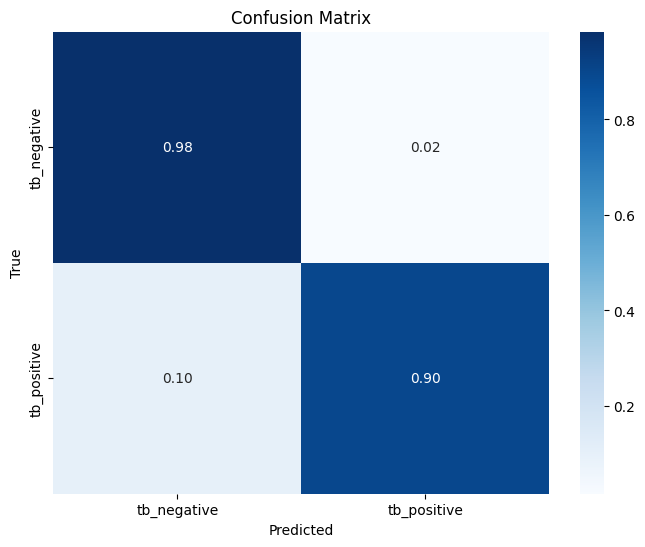

In [37]:
plot_cm(pred_data=pred_data, normalize='true')

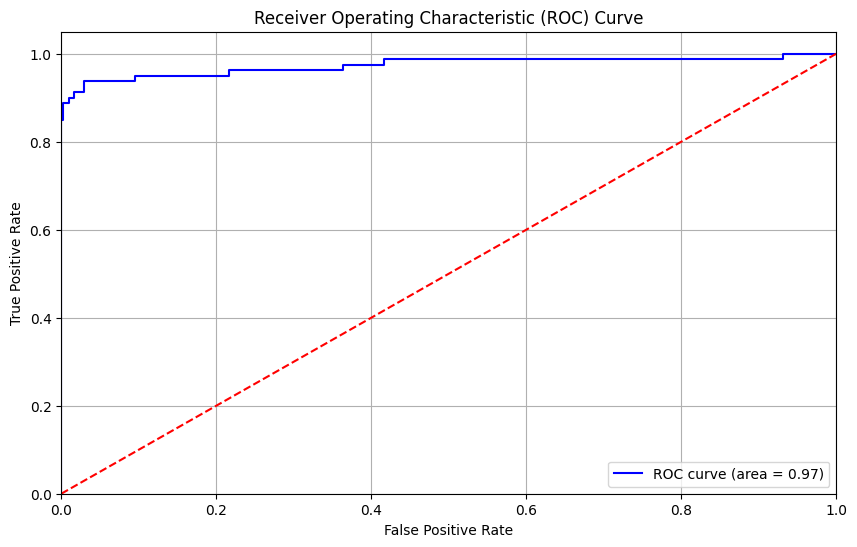

In [38]:
plot_roc_curve(pred_data)

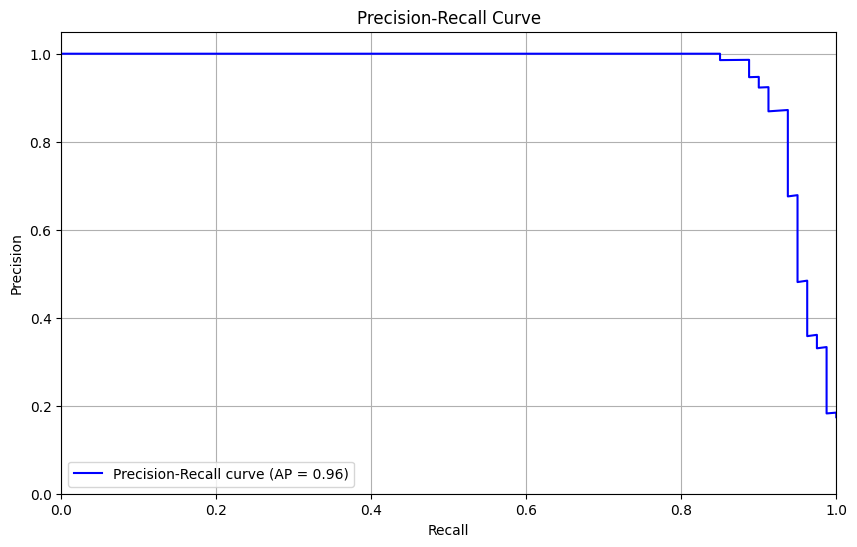

In [39]:
plot_prc_curve(pred_data)

### **Experiment Logging**

In [54]:
experiment_logger = ExperimentLogger()
experiment_logger.save_results(eval_metrics=eval_metrics, config=training_config, history=history ,pred_data=pred_data)

In [56]:
pd.read_csv('experiment_logs/experiment_logs.csv').T

,0
experiment_name,base_resnet_model
datetime,2024-10-04 20:51:05
model_name,resnet50
imb_sampling,False
imb_criterion,False
focal_gamma,0.0
epochs,20
batch_size,16
lr,0.001
weight_decay,0.00001
